<a href="https://colab.research.google.com/github/jonygeta/CUNY-SPS-Data607-Project3/blob/master/Project03_Week09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DATA 620 Spring 2019
#### Week 9 Project 3

2019-04-01

## Assignment

__This is a Team Project!__  For this project, please work with the entire class as one collaborative group!  Your project should be submitted (as an Jupyter Notebook via GitHub). You should all submit a link to the same repository. 

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect? 

Source: Natural Language Processing with Python, exercise 6.10.2.

### Import packages

In [0]:
import nltk
from nltk.corpus import names
from nltk.classify import apply_features
import random
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
from sklearn.utils import shuffle
import re
import itertools

# hide warnings after first occurence
# warnings.filterwarnings(action='once')


### Data import


In [0]:
# check whether nltk data is available if not download
try:
    nltk.data.find('corpora/names/README')
except LookupError:
    nltk.download('names')

# import data
dfNames = \
pd.concat(
    [pd.DataFrame({'name' : names.words('female.txt')
                  , 'gender' : 'female'})
    , pd.DataFrame({'name' : names.words('male.txt')
                    , 'gender' : 'male'})],axis=0,ignore_index=True)

# make all names lowercase
dfNames['name'] = dfNames['name'].str.lower()

# create features of interest and store in new column
dfNames['firstChar'] = dfNames['name'].str[0]
dfNames['firstBi'] = dfNames['name'].str[:2]
dfNames['firstTri'] = dfNames['name'].str[:3]
dfNames['lastChar'] = dfNames['name'].str[-1]
dfNames['lastBi'] = dfNames['name'].str[-2:]
dfNames['lastTri'] = dfNames['name'].str[-3:]
dfNames['cntChar'] = dfNames['name'].str.len()
dfNames['cntUnqChar'] = dfNames['name'].apply(set).apply(len)
dfNames['cntConsns'] = dfNames['name'].str.count(r'[bcdfghjklmnpqrstvwxzy]', flags=re.I)
dfNames['cntVowels'] = dfNames['name'].str.count(r'[aeiou]', flags=re.I)
dfNames['starVowel'] = dfNames['name'].str.match(r'^[aeiou].*$')
dfNames['endVowel'] = dfNames['name'].str.match(r'.*[aeiou]$')

# add count of each letter and logical if letter is present
for letter in 'abcdefghijklmnopqrstuvwxyz':
    dfNames['cnt_' + letter.upper()] = \
    dfNames['name'].str.count(letter)

    dfNames['has_' + letter.upper()] = \
    dfNames['name'].str.match(r'.*' + letter)

# count of syallables
def count_syllable(word):
    word = word.lower()
    vowels = 'aeiouy'

    count = 0
    if word[0] in vowels:
        count += 1
    for i in range(1, len(word)):
        if word[i] in vowels and word[i-1] not in vowels:
            count += 1
    if word.endswith('e'):
        count -= 1
    elif word.endswith('le'):
        count += 1
    elif word.endswith('bile'):
        count -= 1
    elif count == 0:
        count += 1
    return count

dfNames['cntSyll'] = dfNames['name'].apply(count_syllable)

# consonant clusters
def naive_features3(name):
    features = {}
    name_holder = name
    eng_constants = ["bl", "br", "ch", "cl", "cr", "dr", "fl", "fr"\
                     , "gl", "gr", "pl", "pr", "sc", "sh", "sk", "sl"\
                     , "sm", "sn", "sp", "st", "sw", "th", "tr", "tw"\
                     , "wh", "wr", "sch", "scr", "shr", "sph", "spl"\
                     , "spr", "squ", "str", "thr"]
    clusters = []
    for cluster in eng_constants[::-1]:
        if cluster in name_holder:
            name_holder = name_holder.replace(cluster, "")
            clusters.append(cluster)
    features["clusters1"] = clusters[0] if len(clusters) > 0 else None
    features["clusters2"] = clusters[1] if len(clusters) > 1 else None
    features["clusters3"] = clusters[2] if len(clusters) > 2 else None
    return features

# join dictionary of clusters to names data frame
dfNames = \
dfNames.join(
    pd.DataFrame.from_records(
        dfNames['name'].map(naive_features3).tolist()))

# additional features?
## phonetic pronunciation
## dichotomous, based on most common starting/ending letter by gender?

## Exploratory data analysis

To start we looked at the proportion of names starting with a particular letter by gender.  There are some notable differences; we see that Female names more commonly start with a, c, and m than male names and male names start with h, r, s, t, and w.


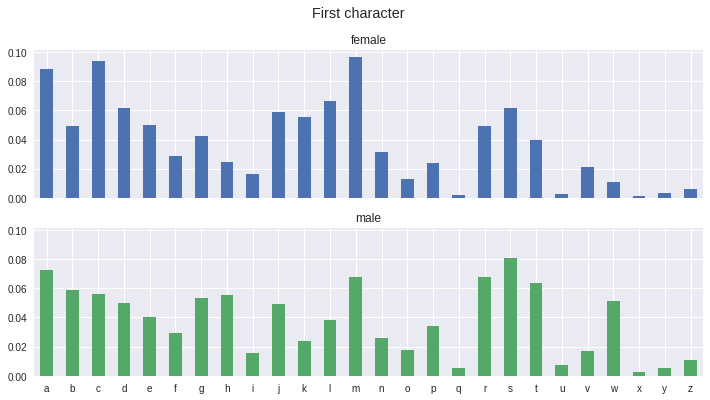

In [0]:
# calculate percentage of names starting with character by gender
# TODO Change Y-axis to percenage, change plot to custom function
dfCrsFstChr = \
pd.crosstab(index=dfNames['firstChar'], 
                     columns=dfNames['gender'], 
                     values=1, 
                     aggfunc='sum', 
                     normalize='columns')# .applymap('{:.2f}%'.format)

# bar plot of first character against gender
pltCrs = \
dfCrsFstChr.plot(kind = 'bar', subplots = True, stacked = False
                 , rot = 0, figsize=(12,6), legend=False
                 , sharey = True, title = 'First character')

plt.xlabel('')
plt.show()

Reviewing the proportion of names ending with a given letter we see that a large proportion of female names end in the letters a and e both of which occur at a considerably higher rate for females than males.  Expanding to all vowels we see the trend continues for for i, but males have a higher proportion for o and y in this data set.

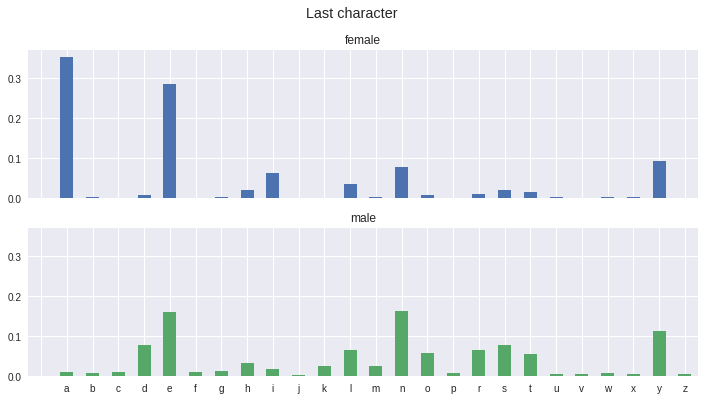

In [0]:
# calculate percentage of names ending with character by gender
dfCrsLstChr = \
pd.crosstab(index=dfNames['lastChar'], 
                     columns=dfNames['gender'], 
                     values=1, 
                     aggfunc='sum', 
                     normalize='columns')# .applymap('{:.2f}%'.format)

# bar plot of first character against gender
pltCrs = \
dfCrsLstChr.plot(kind = 'bar', subplots = True, stacked = False
                 , rot = 0, figsize=(12,6), legend=False
                 , sharey = True, title = 'Last character')

plt.xlabel('')
plt.show()

Exploring the proportion of names containing a particular letter we see that over 50% of female names in the data contain the letter a.

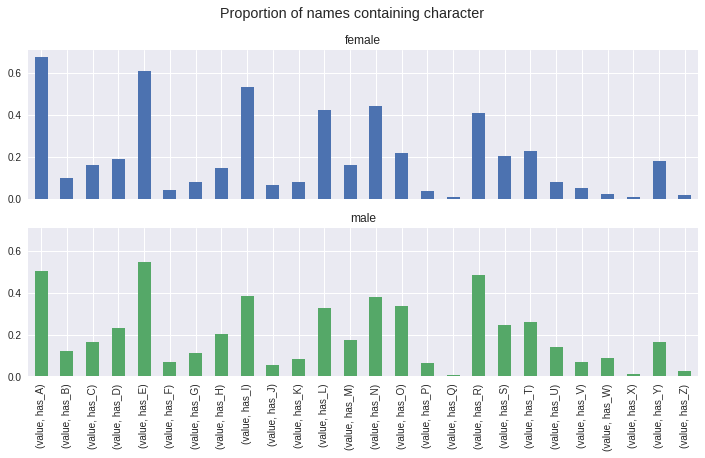

In [0]:
# calculate number of names which have a given letter
dfCrsChrHas = \
dfNames.loc[:, dfNames.columns.to_series().str.match('^has|gender')]\
.melt(id_vars=['gender']).groupby(['gender', 'variable']).sum()\
.unstack().T

# change counts to proportion of names by gender
dfCrsChrHas['female'] = \
dfCrsChrHas['female'] / sum(dfNames['gender'] == 'female')

dfCrsChrHas['male'] = \
dfCrsChrHas['male'] / sum(dfNames['gender'] == 'male')

dfCrsChrHas.plot(kind = 'bar', subplots = True, stacked = False
                 , rot = 90, figsize=(12,6), legend=False
                 , sharey = True, title = 'Proportion of names containing character')


plt.xlabel('')
plt.show()

Looking at the length of names by gender shows a similar distribution for both females and males and is likely not going to provide much information value for classification. Creating a similar visualization (not shown) for number of unique characters, count of consonants, count of vowels, and syllables  produce similar results.

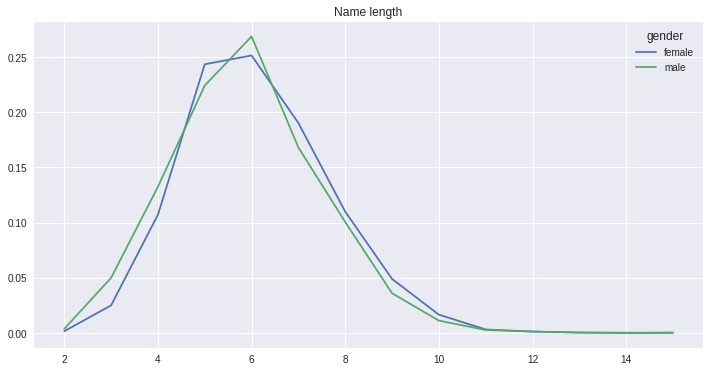

In [0]:
# calculate percentage of name length by gender
dfCrsChrLen = \
pd.crosstab(index=dfNames['cntChar'], columns=dfNames['gender'], 
                     values=1, aggfunc='sum', normalize='columns')

# bar plot of first character against gender
pltCrs = \
dfCrsChrLen.plot(kind = 'line', subplots = False, stacked = False
                 , rot = 0, figsize=(12,6), legend=True
                 , sharey = True, title = 'Name length')

plt.xlabel('')
plt.show()

Comparing the frequency of a name starting or ending with a vowel we see that the number of names starting with vowels vs. consonants are relatively equal by gender, while the number of names ending with a vowel heavily favors names typically associated with females.

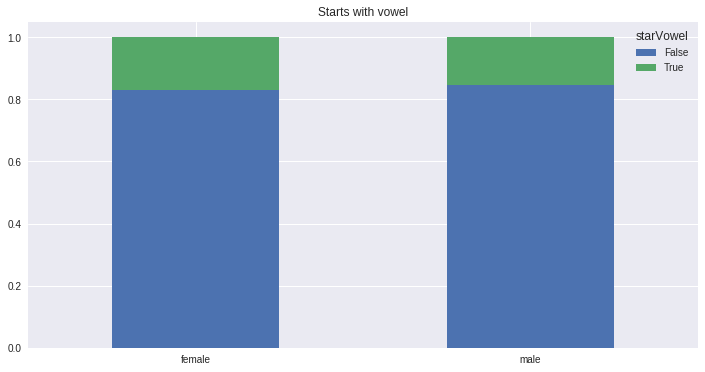

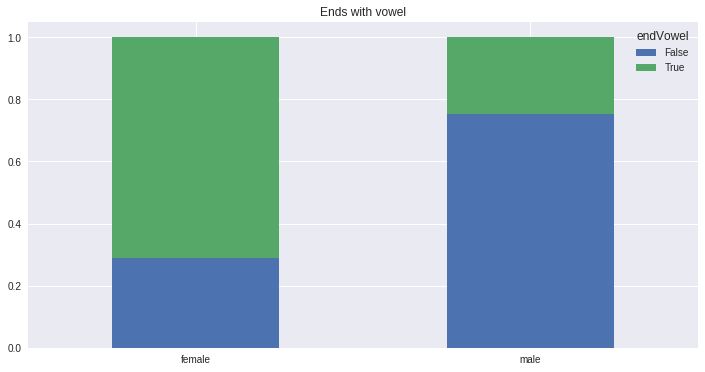

In [0]:
# calculate percentage of names starting with character by gender
dfCrsStrtVwl = \
pd.crosstab(index=dfNames['gender'], columns=dfNames['starVowel'], 
                     values=1, aggfunc='sum', normalize='index')

# bar plot of first character against gender
pltCrs = \
dfCrsStrtVwl.plot(kind = 'bar', subplots = False, stacked = True
                 , rot = 0, figsize=(12,6), legend=True
                 , sharey = True, title = 'Starts with vowel')

plt.xlabel('')
plt.show()

dfCrsEndVwl = \
pd.crosstab(index=dfNames['gender'], columns=dfNames['endVowel'], 
                     values=1, aggfunc='sum', normalize='index')

# bar plot of first character against gender
pltCrs = \
dfCrsEndVwl.plot(kind = 'bar', subplots = False, stacked = True
                 , rot = 0, figsize=(12,6), legend=True
                 , sharey = True, title = 'Ends with vowel')

plt.xlabel('')
plt.show()

## Model development

### Split data

Split the data into three groups, training, development, and testing.

In [0]:
# set random seed for reproducibility
random.seed(20190401)

# randomly sort names list
dfNames = shuffle(dfNames)

# split data into training, development, and testing data sets
dfTest, dfDev, dfTrain = \
dfNames[0:500], dfNames[501:1001], dfNames[1001:]

# print length of data sets
print("Data sizes; Training = {0}, Development = {1}, Testing = {2}"
      .format(len(dfTrain), len(dfDev), len(dfTest)))

Data sizes; Training = 6943, Development = 500, Testing = 500


### Baseline (Naive Bayes)
The baseline model follows the example from Chapter 6 of _Social Network Analysis for Startups_. The model, Naive Bayes Classifier, utilizes the last character and last two characters of each name as features.  The source for the confusion matrix plot function can be found on is from a [StackOverflow question](https://stackoverflow.com/questions/48817300/sklearn-plot-confusion-matrix-combined-across-trainingtest-sets).

Most Informative Features
                  lastBi = 'na'           female : male   =    152.5 : 1.0
                  lastBi = 'la'           female : male   =     72.3 : 1.0
                  lastBi = 'ia'           female : male   =     51.3 : 1.0
                  lastBi = 'ta'           female : male   =     44.4 : 1.0
                lastChar = 'k'              male : female =     43.0 : 1.0
                lastChar = 'a'            female : male   =     37.2 : 1.0
                  lastBi = 'sa'           female : male   =     34.3 : 1.0
                  lastBi = 'rt'             male : female =     30.3 : 1.0
                  lastBi = 'us'             male : female =     25.9 : 1.0
                  lastBi = 'ra'           female : male   =     24.3 : 1.0
Accuracy = 0.794
Confusion matrix, without normalization


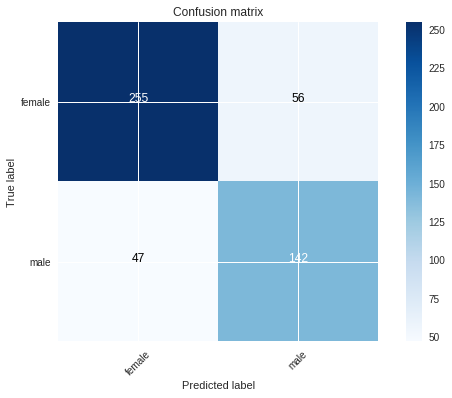

In [0]:
# list of feature columns from dataframe
colFtrNms = ['lastChar', 'lastBi']

# create tuples for train and dev with features as dictionary and gender as classification
tplTrain = \
pd.DataFrame.from_dict(
    {'featues' : dfTrain[list(colFtrNms)].to_dict('records')
     , 'gender' : dfTrain['gender']}).apply(tuple, axis = 1).values.tolist()

tplDev = \
pd.DataFrame.from_dict(
    {'featues' : dfDev[list(colFtrNms)].to_dict('records')
     , 'gender' : dfDev['gender']}).apply(tuple, axis = 1).values.tolist()

# train classifier
bslnMdlTrain = nltk.NaiveBayesClassifier.train(tplTrain)

# show most informative
bslnMdlTrain.show_most_informative_features(10)

# check accuracy on dev data
print("Accuracy = {0}".format(nltk.classify.accuracy(bslnMdlTrain, tplDev)))

# classify dev data
devPred = []
for row in dfDev[list(colFtrNms)].to_dict('records'):
        devPred.append(bslnMdlTrain.classify(row))


# confusion matrix
# print(nltk.ConfusionMatrix(dfDev['gender'].tolist(), devPred))
bslnDevCM = confusion_matrix(dfDev['gender'].tolist(), devPred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# cm = confusion_matrix(y_true, y_pred)
# np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(bslnDevCM, classes=['female', 'male'],
                      title='Confusion matrix', normalize=False)


### Class developed model

__TODO__ show more model iterations?

#### Naive Bayes

Building on what was done in the textbook example this model incudes; first letter, last letter, first trigram, last trigram, and three features indicating whether the name has consonant clusters.


Most Informative Features
                lastChar = 'k'              male : female =     43.0 : 1.0
                lastChar = 'a'            female : male   =     37.2 : 1.0
                 lastTri = 'ita'          female : male   =     26.4 : 1.0
                 lastTri = 'tta'          female : male   =     23.8 : 1.0
                 lastTri = 'son'            male : female =     21.4 : 1.0
                 lastTri = 'ard'            male : female =     18.9 : 1.0
                 lastTri = 'old'            male : female =     18.1 : 1.0
                firstTri = 'dor'          female : male   =     16.0 : 1.0
                lastChar = 'f'              male : female =     15.9 : 1.0
                 lastTri = 'ert'            male : female =     15.8 : 1.0
Accuracy = 0.864
Confusion matrix, without normalization


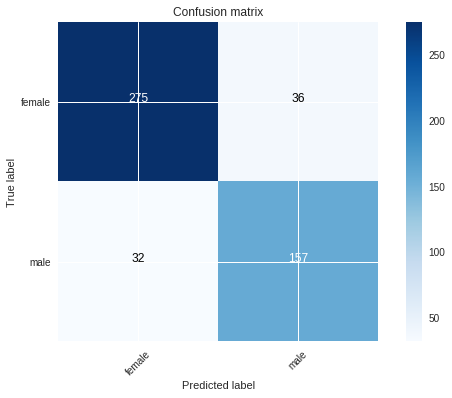

In [0]:
# list of feature columns from dataframe
colFtrNms = ['firstChar', 'lastChar', 'firstTri', 'lastTri'\
             , 'cntSyll',  'clusters1', 'clusters2', 'clusters3']

# create tuples for train and dev with features as dictionary and gender as classification
tplTrain = \
pd.DataFrame.from_dict(
    {'featues' : dfTrain[list(colFtrNms)].to_dict('records')
     , 'gender' : dfTrain['gender']}).apply(tuple, axis = 1).values.tolist()

tplDev = \
pd.DataFrame.from_dict(
    {'featues' : dfDev[list(colFtrNms)].to_dict('records')
     , 'gender' : dfDev['gender']}).apply(tuple, axis = 1).values.tolist()

# train classifier
nbMdlTrain = nltk.NaiveBayesClassifier.train(tplTrain)

# show most informative
nbMdlTrain.show_most_informative_features(10)

# check accuracy on dev data
print("Accuracy = {0}".format(nltk.classify.accuracy(nbMdlTrain, tplDev)))

# classify dev data
devPred = []
for row in dfDev[list(colFtrNms)].to_dict('records'):
        devPred.append(nbMdlTrain.classify(row))


# confusion matrix
# print(nltk.ConfusionMatrix(dfDev['gender'].tolist(), devPred))
bslnDevCM = confusion_matrix(dfDev['gender'].tolist(), devPred)

plt.figure()
plot_confusion_matrix(bslnDevCM, classes=['female', 'male'],
                      title='Confusion matrix', normalize=False)


#### Decision tree


https://pythonprogramminglanguage.com/decision-tree-visual-example/

https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176

Accuracy = 0.762
Confusion matrix, without normalization


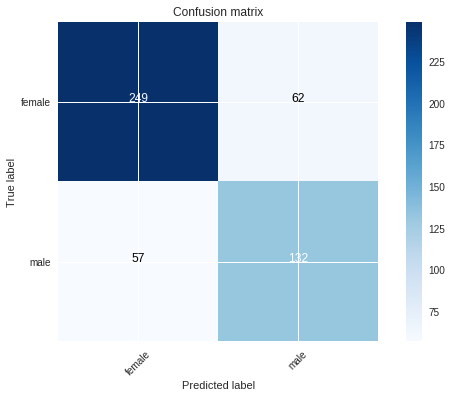

In [0]:
# Repeat yohannes naive bayes model using decision tree
# list of feature columns from dataframe
colFtrNms = ['firstChar', 'lastChar', 'firstTri', 'lastTri'\
             , 'cntSyll', 'clusters1', 'clusters2', 'clusters3']

# create tuples for train and dev with features as dictionary and gender as classification
tplTrain = \
pd.DataFrame.from_dict(
    {'featues' : dfTrain[list(colFtrNms)].to_dict('records')
     , 'gender' : dfTrain['gender']}).apply(tuple, axis = 1).values.tolist()

tplDev = \
pd.DataFrame.from_dict(
    {'featues' : dfDev[list(colFtrNms)].to_dict('records')
     , 'gender' : dfDev['gender']}).apply(tuple, axis = 1).values.tolist()

# train classifier
dtMdlTrain = nltk.DecisionTreeClassifier.train(tplTrain, entropy_cutoff=0,support_cutoff=0)

# check accuracy on dev data
print("Accuracy = {0}".format(nltk.classify.accuracy(dtMdlTrain, tplDev)))

# classify dev data
devPred = []
for row in dfDev[list(colFtrNms)].to_dict('records'):
        devPred.append(dtMdlTrain.classify(row))


# confusion matrix
# print(nltk.ConfusionMatrix(dfDev['gender'].tolist(), devPred))
bslnDevCM = confusion_matrix(dfDev['gender'].tolist(), devPred)

plt.figure()
plot_confusion_matrix(bslnDevCM, classes=['female', 'male'],
                      title='Confusion matrix', normalize=False)


In [0]:
from sklearn import preprocessing

def clean_cat_data(tplTrain, columns):
  le = preprocessing.LabelEncoder()

  features = [i[0] for i in tplTrain]
  genders = [i[1] for i in tplTrain]
  feat_df = pd.DataFrame.from_dict(features)
  
  for col in columns:
    le.fit(feat_df[col])
    feat_df[col] = le.transform(feat_df[col])
    
  sample_feats = feat_df[columns]
  
  return sample_feats, genders

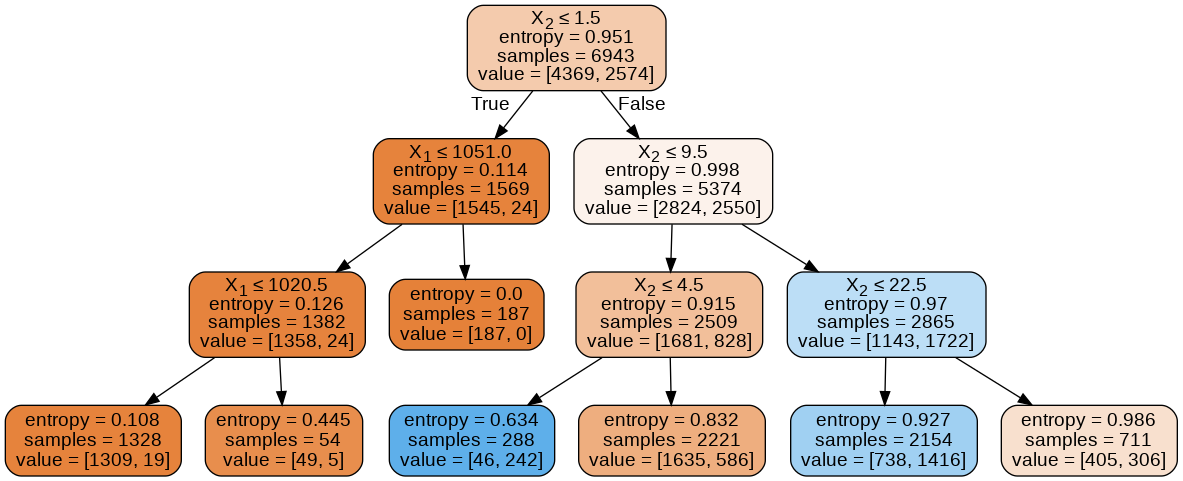

In [0]:
from sklearn.tree import DecisionTreeClassifier

sample_feats, genders = clean_cat_data(tplTrain, ['firstChar','firstTri','lastChar','lastTri'])

dtree=DecisionTreeClassifier(criterion="entropy", max_depth=3)
dtree.fit(sample_feats,genders)

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [0]:
from sklearn import metrics
test_feats, test_genders = clean_cat_data(tplDev, ['firstChar','firstTri','lastChar','lastTri'])

y_pred = dtree.predict(test_feats)
print("Accuracy:",metrics.accuracy_score(test_genders, y_pred))

Accuracy: 0.646


### Selected model

__TODO__ select best model and explain decision.  build table showing dev vs. test accuracy for all models generated?

In [0]:
# place holder change to whichever model is chosen
# test accuracy of selected model on reserved test data
tplTest = \
pd.DataFrame.from_dict(
    {'featues' : dfTest[list(colFtrNms)].to_dict('records')
     , 'gender' : dfTest['gender']}).apply(tuple, axis = 1).values.tolist()

print("Accuracy = {0}".format(nltk.classify.accuracy(nbMdlTrain, tplTest)))

## Final evaluation

__TODO__ evaluate on test data, compare evaluation to development data; overfit/underfit etc.